In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, make_scorer
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import IsolationForest

warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.2 MB/s eta 0:00:00


In [6]:
train = pd.read_csv('https://raw.githubusercontent.com/Asmaa6777/Vegetation-Mapping-/main/Train%20(6).csv')
test = pd.read_csv('https://raw.githubusercontent.com/Asmaa6777/Vegetation-Mapping-/main/Test%20(4).csv')
sub = pd.read_csv('https://raw.githubusercontent.com/Asmaa6777/Vegetation-Mapping-/main/submission%20(5).csv')
id = test['id']

In [7]:
X_train = train.copy()
X_test = test.copy()
X_test = test.drop('id', axis=1)
X_train = X_train.drop('Target', axis=1)
X_train = X_train.drop('id', axis=1)
y_train = train['Target']

In [8]:
test.shape

(923, 42)

In [9]:
isolation_forest = IsolationForest(contamination=0.1)
is_inlier = isolation_forest.fit_predict(X_train)

# Keep only inliers
X_train_cleaned = X_train[is_inlier == 1]
y_train_cleaned = y_train[is_inlier == 1]

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [11]:
# Assuming you have your features in X and target variable in y
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_cleaned , y_train_cleaned, test_size=0.2, random_state=42 )

In [12]:
# Initialize CatBoost with class weights
cat = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45,  # Adjust this based on the imbalance
                           random_seed=42)

# Fit the model
cat_modle = cat.fit(X_train_cleaned, y_train_cleaned, eval_set=(X_valid, y_valid), verbose=100)


0:	learn: 3.7441379	test: 3.7439339	best: 3.7439339 (0)	total: 619ms	remaining: 5m 9s
100:	learn: 2.2180205	test: 2.1816067	best: 2.1816067 (100)	total: 36.6s	remaining: 2m 24s
200:	learn: 1.7067632	test: 1.6824892	best: 1.6824892 (200)	total: 1m 13s	remaining: 1m 48s
300:	learn: 1.3053321	test: 1.2846169	best: 1.2846169 (300)	total: 1m 49s	remaining: 1m 12s
400:	learn: 1.0046251	test: 0.9920585	best: 0.9920585 (400)	total: 2m 27s	remaining: 36.4s
499:	learn: 0.7573571	test: 0.7497037	best: 0.7497037 (499)	total: 3m 4s	remaining: 0us

bestTest = 0.7497037413
bestIteration = 499



In [19]:

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_results = []
valid_results = []

# Reset the index of X_train_cleaned and y_train_cleaned before the split
X_train_cleaned = X_train_cleaned.reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

# Now, apply StratifiedKFold
for train_index, valid_index in skf.split(X_train_cleaned, y_train_cleaned):
    # Use iloc to select rows based on indices
    X_train_fold, X_valid_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[valid_index]

    # Determine the number of unique classes in y_train_fold
    num_classes = len(np.unique(y_train_fold))

    # Initialize CatBoost with class weights based on the number of classes
    cat = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45,
                           random_seed=42)

    # Fit the model
    cat_model = cat.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold), verbose=100)

    # Evaluate the model
    train_score = cat_model.score(X_train_fold, y_train_fold)
    valid_score = cat_model.score(X_valid_fold, y_valid_fold)

    train_results.append(train_score)
    valid_results.append(valid_score)

    pred_v = cat_model.predict_proba(X_valid_fold)



0:	learn: 3.7468030	test: 3.7661695	best: 3.7661695 (0)	total: 656ms	remaining: 5m 27s
100:	learn: 2.1465567	test: 3.3719248	best: 3.3602991 (72)	total: 37.5s	remaining: 2m 28s
200:	learn: 1.6060699	test: 3.4132254	best: 3.3602991 (72)	total: 1m 13s	remaining: 1m 49s
300:	learn: 1.1863448	test: 3.4648157	best: 3.3602991 (72)	total: 1m 47s	remaining: 1m 11s
400:	learn: 0.8794904	test: 3.5082685	best: 3.3602991 (72)	total: 2m 23s	remaining: 35.5s
499:	learn: 0.6519351	test: 3.5509498	best: 3.3602991 (72)	total: 2m 59s	remaining: 0us

bestTest = 3.36029908
bestIteration = 72

Shrink model to first 73 iterations.
0:	learn: 3.7457334	test: 3.7725389	best: 3.7725389 (0)	total: 582ms	remaining: 4m 50s
100:	learn: 2.1507977	test: 3.3770012	best: 3.3681357 (68)	total: 35.8s	remaining: 2m 21s
200:	learn: 1.6002798	test: 3.4193397	best: 3.3681357 (68)	total: 1m 11s	remaining: 1m 46s
300:	learn: 1.2009220	test: 3.4702656	best: 3.3681357 (68)	total: 1m 45s	remaining: 1m 9s
400:	learn: 0.8903983	tes

In [20]:
all_labels = np.unique(y_train_cleaned)

log_loss_value = log_loss(y_valid_fold, pred_v, labels=all_labels)
print(f"Log Loss: {log_loss_value}")


Log Loss: 3.343405405880052


In [23]:
pred = cat_modle.predict_proba(X_train_cleaned)
log_loss_value = log_loss(y_train_cleaned, pred)
print(f"Log Loss: {log_loss_value}")

Log Loss: 0.7573570731001644


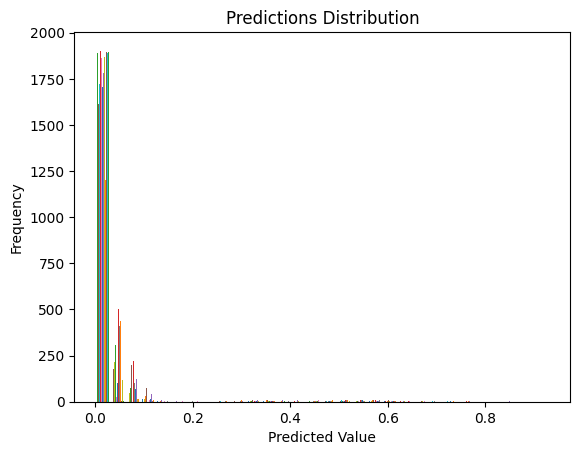

In [25]:
plt.hist(pred, bins=30)
plt.title("Predictions Distribution")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

In [26]:
submission = pd.DataFrame({'id': id})
columns = [f'Target_{i}' for i in range(125)]
submission[columns] = 0.00001

y_pred_proba = cat_modle.predict_proba(X_test)

for i, class_label in enumerate(cat_modle.classes_):
    submission['Target_' + str(class_label)] = y_pred_proba[:, i]

In [27]:
submission

,id,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,...,Target_115,Target_116,Target_117,Target_118,Target_119,Target_120,Target_121,Target_122,Target_123,Target_124
0,id_utdshhcma9,0.00001,0.024096,0.000648,0.003210,0.013272,0.000639,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000161,0.00001,0.00001,0.00001,0.00001,0.000636,0.00001
1,id_wpr03x91k8,0.00001,0.014082,0.000548,0.005178,0.006239,0.004734,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000401,0.00001,0.00001,0.00001,0.00001,0.002915,0.00001
2,id_ihn04pau10,0.00001,0.027014,0.000520,0.006213,0.015648,0.001048,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000581,0.00001,0.00001,0.00001,0.00001,0.005496,0.00001
3,id_dujctwctkv,0.00001,0.065913,0.000989,0.007348,0.112147,0.005121,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000315,0.00001,0.00001,0.00001,0.00001,0.000971,0.00001
4,id_fjf3v7c0h6,0.00001,0.098354,0.001563,0.009336,0.008999,0.000258,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000193,0.00001,0.00001,0.00001,0.00001,0.000470,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,id_4zy8kfq53o,0.00001,0.081547,0.000251,0.002576,0.008804,0.002816,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000108,0.00001,0.00001,0.00001,0.00001,0.000818,0.00001
919,id_qai88fi8g4,0.00001,0.018351,0.005621,0.029263,0.037062,0.009442,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.001033,0.00001,0.00001,0.00001,0.00001,0.001535,0.00001
920,id_eqahzvkqzx,0.00001,0.011233,0.000673,0.007651,0.005490,0.002607,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000334,0.00001,0.00001,0.00001,0.00001,0.000414,0.00001
921,id_thyigbf2aa,0.00001,0.058852,0.003120,0.005210,0.004899,0.002637,0.00001,0.00001,0.00001,...,0.00001,0.00001,0.00001,0.000212,0.00001,0.00001,0.00001,0.00001,0.000693,0.00001


In [28]:
sub

,id,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,...,Target_115,Target_116,Target_117,Target_118,Target_119,Target_120,Target_121,Target_122,Target_123,Target_124
0,id_0,0.438347,0.851061,0.966168,0.341747,0.650042,0.066717,0.075791,0.507326,0.555521,...,0.836912,0.445287,0.589186,0.699029,0.074704,0.665842,0.442513,0.355544,0.152600,0.134683
1,id_1,0.565642,0.615802,0.677542,0.230855,0.735124,0.546815,0.441809,0.166270,0.597937,...,0.166521,0.458990,0.461271,0.501299,0.864769,0.400230,0.667635,0.249743,0.757617,0.976212
2,id_2,0.036709,0.630361,0.234653,0.854185,0.377753,0.702878,0.531959,0.459548,0.445115,...,0.431271,0.835641,0.440805,0.076602,0.185930,0.158767,0.998277,0.300903,0.161452,0.055259
3,id_3,0.725053,0.492855,0.343015,0.734363,0.020648,0.653114,0.752422,0.202715,0.409347,...,0.700429,0.396790,0.546269,0.142183,0.999901,0.044354,0.692089,0.688210,0.969250,0.637524
4,id_4,0.191372,0.845806,0.136797,0.503039,0.421207,0.016428,0.963039,0.022698,0.085996,...,0.812558,0.452537,0.471067,0.495789,0.181787,0.430111,0.270977,0.689454,0.122307,0.551863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2118,id_2118,0.262129,0.304762,0.406346,0.774544,0.065903,0.603115,0.722647,0.022611,0.407640,...,0.940148,0.648012,0.471634,0.174771,0.156917,0.719496,0.678512,0.915763,0.413135,0.728303
2119,id_2119,0.095131,0.447390,0.279403,0.109684,0.304521,0.617234,0.590694,0.928764,0.606812,...,0.857649,0.551243,0.544300,0.576428,0.415837,0.963984,0.053101,0.258866,0.104772,0.550319
2120,id_2120,0.491155,0.305032,0.221534,0.343905,0.499069,0.269462,0.053667,0.173733,0.304702,...,0.446139,0.424264,0.894880,0.544505,0.136195,0.507469,0.659142,0.162943,0.862594,0.133956
2121,id_2121,0.436639,0.561967,0.951434,0.957295,0.658245,0.913562,0.660419,0.719754,0.634709,...,0.197783,0.901564,0.145121,0.879382,0.230877,0.439661,0.089016,0.605384,0.973388,0.661553


In [29]:
submission.to_csv('submission_3.332917153288488', index=False)